In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit

from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib

import warnings
warnings.filterwarnings("ignore")


c:\Users\memol\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cargar los datos
data = pd.read_csv('data_clean.csv')
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.sort_values('Date', inplace=True)

In [3]:
# Seleccionar las columnas relevantes para PCA
features = data.select_dtypes(include=[float, int, bool]).drop(columns=['Store', 'Sales', 'Customers', 'Cluster'])

# Escalar los datos
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Aplicar PCA
pca = PCA(n_components=0.99)  # Retener el 99% de la varianza
pca_features = pca.fit_transform(scaled_features)

# Añadir los componentes principales al DataFrame
pca_columns = [f'PC{i+1}' for i in range(pca_features.shape[1])]
pca_df = pd.DataFrame(pca_features, columns=pca_columns)
combined_data = pd.concat([data.reset_index(drop=True), pca_df], axis=1)


# SARIMA

In [4]:
def train_sarimax(cluster_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    # Agrupar por fecha y sumar ventas y clientes
    cluster_data = cluster_data.groupby('Date').agg({'Sales': 'sum', 'Customers': 'sum'}).reset_index()
    
    # Entrenar el modelo SARIMAX
    model = SARIMAX(cluster_data['Sales'], 
                    order=order, 
                    seasonal_order=seasonal_order,
                    exog=cluster_data[['Customers']])
    results = model.fit(disp=False)
    return results


In [5]:
# Separar los datos por cluster
clustered_sales_data = {cluster: combined_data[combined_data['Cluster'] == cluster] for cluster in combined_data['Cluster'].unique()}

# Entrenar el modelo para cada cluster
sarimax_models = {}
for cluster, data in clustered_sales_data.items():
    sarimax_models[cluster] = train_sarimax(data)
    print(f'Modelo SARIMAX para el Cluster {cluster} entrenado.')


Modelo SARIMAX para el Cluster 1 entrenado.
Modelo SARIMAX para el Cluster 0 entrenado.
Modelo SARIMAX para el Cluster 2 entrenado.


In [6]:
sarimax_param_grid = {
    'order': [(1, 1, 1), (2, 1, 2), (3, 1, 3)],
    'seasonal_order': [(1, 1, 1, 12), (1, 0, 1, 12), (2, 1, 2, 12)]
}

# Generar todas las combinaciones de hiperparámetros
sarimax_grid = list(ParameterGrid(sarimax_param_grid))


### "order"

Este parámetro define la configuración de los componentes no estacionales del modelo:

p (AutoRegressive part): Número de términos autoregresivos. Un AR(p) es un modelo en el cual la variable actual depende linealmente de sus p propios valores previos.

d (Integrated part): Orden de diferenciación. Este valor indica cuántas veces los datos necesitan ser diferenciados para hacer la serie temporal estacionaria, es decir, que sus propiedades estadísticas como la media y la varianza no cambian con el tiempo.

q (Moving Average part): Número de términos de media móvil. Un MA(q) es un modelo en el cual la variable actual depende linealmente de los q términos de error pasados.

### "seasonal_order"

Este parámetro especifica la configuración de los componentes estacionales del modelo:

P (Seasonal AutoRegressive part): Número de términos autoregresivos estacionales.

D (Seasonal Integrated part): Orden de diferenciación estacional, que se aplica a los datos con una periodicidad específica.

Q (Seasonal Moving Average part): Número de términos de media móvil estacionales.

s (Periodicity): Número de periodos en cada temporada. Por ejemplo, un s de 12 para datos mensuales podría representar una estacionalidad anual.

In [7]:
def evaluate_sarimax_params_cv(cluster_data, params, n_splits=3):
    # Crea un objeto TimeSeriesSplit para la validación cruzada de series temporales con n_splits partes
    tscv = TimeSeriesSplit(n_splits=n_splits)
    errors = []  

    # Agrupa los datos por fecha, sumando las ventas y clientes de cada día, y reinicia el índice
    cluster_data = cluster_data.groupby('Date').agg({'Sales': 'sum', 'Customers': 'sum'}).reset_index()
    
    # Itera sobre los índices de entrenamiento y prueba generados por TimeSeriesSplit
    for train_index, test_index in tscv.split(cluster_data):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]  # Divide los datos en entrenamiento y prueba
        
        # Instancia el modelo SARIMAX con los parámetros dados y los datos de entrenamiento
        model = SARIMAX(train['Sales'], 
                        order=params['order'], 
                        seasonal_order=params['seasonal_order'],
                        exog=train[['Customers']])
        results = model.fit(disp=False)  
        
        # Realiza las predicciones para el conjunto de prueba utilizando la variable exógena correspondiente
        predictions = results.forecast(steps=len(test), exog=test[['Customers']])
        
        # Calcula el error absoluto medio (MAE) entre las ventas reales y las predicciones
        mae = mean_absolute_error(test['Sales'], predictions)
        errors.append(mae)  # Añade el MAE de esta partición a la lista de errores
    
    # Calcula el error absoluto medio promedio de todas las particiones
    avg_mae = np.mean(errors)
    return avg_mae  


In [8]:
best_sarimax_params = {}
best_sarimax_scores = {}

for cluster, data in clustered_sales_data.items():
    best_score = float('inf')
    for params in sarimax_grid:
        score = evaluate_sarimax_params_cv(data, params)
        if score < best_score:
            best_score = score
            best_sarimax_params[cluster] = params
    best_sarimax_scores[cluster] = best_score
    print(f'Mejores parámetros SARIMAX para el Cluster {cluster}: {best_sarimax_params[cluster]} con MAE: {best_sarimax_scores[cluster]}')


Mejores parámetros SARIMAX para el Cluster 1: {'order': (3, 1, 3), 'seasonal_order': (1, 0, 1, 12)} con MAE: 186297.61936233044
Mejores parámetros SARIMAX para el Cluster 0: {'order': (3, 1, 3), 'seasonal_order': (1, 0, 1, 12)} con MAE: 205579.0743394762
Mejores parámetros SARIMAX para el Cluster 2: {'order': (1, 1, 1), 'seasonal_order': (1, 0, 1, 12)} con MAE: 51744.10628072592


In [9]:
def train_best_sarimax(cluster_data, params):
    cluster_data = cluster_data.groupby('Date').agg({'Sales': 'sum', 'Customers': 'sum'}).reset_index()
    model = SARIMAX(cluster_data['Sales'], 
                    order=params['order'], 
                    seasonal_order=params['seasonal_order'],
                    exog=cluster_data[['Customers']])
    results = model.fit(disp=False)
    return results


In [10]:
best_sarimax_models = {}
for cluster, data in clustered_sales_data.items():
    best_sarimax_models[cluster] = train_best_sarimax(data, best_sarimax_params[cluster])
    print(f'Modelo SARIMAX optimizado para el Cluster {cluster} entrenado.')


Modelo SARIMAX optimizado para el Cluster 1 entrenado.
Modelo SARIMAX optimizado para el Cluster 0 entrenado.
Modelo SARIMAX optimizado para el Cluster 2 entrenado.


In [41]:
def evaluate_sarimax_performance(models, data, steps=30):
    performance = []
    
    # Iterar sobre cada modelo y su cluster correspondiente
    for cluster, model in models.items():
        # Filtrar los datos por cluster y agregar las ventas y clientes por fecha
        cluster_data = data[data['Cluster'] == cluster]
        cluster_data = cluster_data.groupby('Date').agg({'Sales': 'sum', 'Customers': 'sum'}).reset_index()
        
        actual = cluster_data['Sales'][-steps:]
        predictions = model.forecast(steps=steps, exog=cluster_data[['Customers']][-steps:])
        
        mae = mean_absolute_error(actual, predictions)
        rmse = np.sqrt(mean_squared_error(actual, predictions))
        
        performance.append({'Cluster': cluster, 'MAE': mae, 'RMSE': rmse})
    
    performance_df = pd.DataFrame(performance)
    
    return performance_df

# Supongamos que tienes modelos SARIMAX guardados en best_sarimax_models y los datos combinados en combined_data
sarimax_performance_df = evaluate_sarimax_performance(best_sarimax_models, combined_data, steps=30)
print("SARIMAX Performance:\n", sarimax_performance_df)


SARIMAX Performance:
    Cluster            MAE           RMSE
0        1  174519.758478  229752.286730
1        0  222280.379964  302847.866168
2        2   47856.633952   61928.573777


# PROPHET

In [12]:
def train_prophet(cluster_data, params):
    cluster_data = cluster_data.groupby('Date').agg({'Sales': 'sum', 'Customers': 'sum'}).reset_index()
    cluster_data.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)
    
    model = Prophet(
        yearly_seasonality=params['yearly_seasonality'],
        weekly_seasonality=params['weekly_seasonality'],
        seasonality_mode=params['seasonality_mode'],
        changepoint_prior_scale=params['changepoint_prior_scale']
    )
    model.add_regressor('Customers')
    model.fit(cluster_data)
    return model


In [13]:
prophet_params = {
    'yearly_seasonality': True,
    'weekly_seasonality': False,
    'seasonality_mode': 'additive',
    'changepoint_prior_scale': 0.05
}

prophet_models = {}
for cluster, data in clustered_sales_data.items():
    prophet_models[cluster] = train_prophet(data, prophet_params)
    print(f'Modelo Prophet para el Cluster {cluster} entrenado.')


18:23:11 - cmdstanpy - INFO - Chain [1] start processing
18:23:11 - cmdstanpy - INFO - Chain [1] done processing
18:23:11 - cmdstanpy - INFO - Chain [1] start processing


Modelo Prophet para el Cluster 1 entrenado.


18:23:11 - cmdstanpy - INFO - Chain [1] done processing
18:23:11 - cmdstanpy - INFO - Chain [1] start processing


Modelo Prophet para el Cluster 0 entrenado.


18:23:11 - cmdstanpy - INFO - Chain [1] done processing


Modelo Prophet para el Cluster 2 entrenado.


In [14]:
prophet_param_grid = {
    'yearly_seasonality': [True, False],
    'weekly_seasonality': [True, False],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1.0]
}

# Generar todas las combinaciones de hiperparámetros
prophet_grid = list(ParameterGrid(prophet_param_grid))


### "yearly_seasonality"

Tipo: Booleano (True o False)

Este parámetro indica si el modelo debe incluir un componente de estacionalidad anual. Si está activado (True), Prophet modelará un patrón estacional que se repite cada año. La decisión de activarlo o no dependerá de si los datos muestran una clara estacionalidad anual.

### "weekly_seasonality"
   
Tipo: Booleano (True o False)

Similar al parámetro anterior pero en una escala semanal. Si se activa, Prophet intentará capturar patrones semanales en los datos. Esto es útil para datos donde hay variaciones significativas durante la semana.

### "seasonality_mode"

Tipo: Categórico ('additive' o 'multiplicative')

Este parámetro define cómo se modela la estacionalidad en relación con la tendencia.

'additive': La estacionalidad se suma a la tendencia. Es útil cuando las fluctuaciones estacionales no cambian en magnitud a lo largo del tiempo.

'multiplicative': La estacionalidad multiplica la tendencia. Es efectivo cuando las fluctuaciones estacionales aumentan o disminuyen en proporción a la tendencia.

### "changepoint_prior_scale"
 
Tipo: Numérico (varios valores posibles, por ejemplo, 0.01, 0.1, 0.5, 1.0)

Este parámetro ajusta la flexibilidad del modelo en relación a la detección de puntos de cambio en la tendencia de los datos. Los puntos de cambio son los momentos en que la serie temporal tiene grandes cambios en su trayectoria.

Valores más bajos (como 0.01): El modelo es menos flexible, con menos cambios bruscos en la tendencia.

Valores más altos (como 1.0): El modelo es más flexible, permitiendo más cambios bruscos en la tendencia.

In [15]:
def evaluate_prophet_params_cv(cluster_data, params, n_splits=3):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    errors = []

    cluster_data = cluster_data.groupby('Date').agg({'Sales': 'sum', 'Customers': 'sum'}).reset_index()
    cluster_data.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)
    
    for train_index, test_index in tscv.split(cluster_data):
        train, test = cluster_data.iloc[train_index], cluster_data.iloc[test_index]
        
        model = Prophet(
            yearly_seasonality=params['yearly_seasonality'],
            weekly_seasonality=params['weekly_seasonality'],
            seasonality_mode=params['seasonality_mode'],
            changepoint_prior_scale=params['changepoint_prior_scale']
        )
        model.add_regressor('Customers')
        model.fit(train)
        
        future = test[['ds', 'Customers']].copy()
        forecast = model.predict(future)
        y_pred = forecast['yhat']
        y_true = test['y']
        
        mae = mean_absolute_error(y_true, y_pred)
        errors.append(mae)
    
    avg_mae = np.mean(errors)
    return avg_mae


In [16]:
best_prophet_params = {}
best_prophet_scores = {}

for cluster, data in clustered_sales_data.items():
    best_score = float('inf')
    for params in prophet_grid:
        score = evaluate_prophet_params_cv(data, params)
        if score < best_score:
            best_score = score
            best_prophet_params[cluster] = params
    best_prophet_scores[cluster] = best_score
    print(f'Mejores parámetros Prophet para el Cluster {cluster}: {best_prophet_params[cluster]} con MAE: {best_prophet_scores[cluster]}')


18:23:11 - cmdstanpy - INFO - Chain [1] start processing
18:23:11 - cmdstanpy - INFO - Chain [1] done processing
18:23:12 - cmdstanpy - INFO - Chain [1] start processing
18:23:12 - cmdstanpy - INFO - Chain [1] done processing
18:23:12 - cmdstanpy - INFO - Chain [1] start processing
18:23:12 - cmdstanpy - INFO - Chain [1] done processing
18:23:12 - cmdstanpy - INFO - Chain [1] start processing
18:23:12 - cmdstanpy - INFO - Chain [1] done processing
18:23:12 - cmdstanpy - INFO - Chain [1] start processing
18:23:12 - cmdstanpy - INFO - Chain [1] done processing
18:23:13 - cmdstanpy - INFO - Chain [1] start processing
18:23:13 - cmdstanpy - INFO - Chain [1] done processing
18:23:13 - cmdstanpy - INFO - Chain [1] start processing
18:23:13 - cmdstanpy - INFO - Chain [1] done processing
18:23:13 - cmdstanpy - INFO - Chain [1] start processing
18:23:13 - cmdstanpy - INFO - Chain [1] done processing
18:23:13 - cmdstanpy - INFO - Chain [1] start processing
18:23:13 - cmdstanpy - INFO - Chain [1]

Mejores parámetros Prophet para el Cluster 1: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': False} con MAE: 155087.39435418718


18:23:36 - cmdstanpy - INFO - Chain [1] start processing
18:23:36 - cmdstanpy - INFO - Chain [1] done processing
18:23:37 - cmdstanpy - INFO - Chain [1] start processing
18:23:37 - cmdstanpy - INFO - Chain [1] done processing
18:23:37 - cmdstanpy - INFO - Chain [1] start processing
18:23:37 - cmdstanpy - INFO - Chain [1] done processing
18:23:37 - cmdstanpy - INFO - Chain [1] start processing
18:23:37 - cmdstanpy - INFO - Chain [1] done processing
18:23:37 - cmdstanpy - INFO - Chain [1] start processing
18:23:37 - cmdstanpy - INFO - Chain [1] done processing
18:23:37 - cmdstanpy - INFO - Chain [1] start processing
18:23:37 - cmdstanpy - INFO - Chain [1] done processing
18:23:38 - cmdstanpy - INFO - Chain [1] start processing
18:23:38 - cmdstanpy - INFO - Chain [1] done processing
18:23:38 - cmdstanpy - INFO - Chain [1] start processing
18:23:38 - cmdstanpy - INFO - Chain [1] done processing
18:23:38 - cmdstanpy - INFO - Chain [1] start processing
18:23:38 - cmdstanpy - INFO - Chain [1]

Mejores parámetros Prophet para el Cluster 0: {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': False} con MAE: 180263.4599789887


18:24:01 - cmdstanpy - INFO - Chain [1] start processing
18:24:01 - cmdstanpy - INFO - Chain [1] done processing
18:24:01 - cmdstanpy - INFO - Chain [1] start processing
18:24:01 - cmdstanpy - INFO - Chain [1] done processing
18:24:01 - cmdstanpy - INFO - Chain [1] start processing
18:24:01 - cmdstanpy - INFO - Chain [1] done processing
18:24:01 - cmdstanpy - INFO - Chain [1] start processing
18:24:02 - cmdstanpy - INFO - Chain [1] done processing
18:24:02 - cmdstanpy - INFO - Chain [1] start processing
18:24:02 - cmdstanpy - INFO - Chain [1] done processing
18:24:02 - cmdstanpy - INFO - Chain [1] start processing
18:24:02 - cmdstanpy - INFO - Chain [1] done processing
18:24:02 - cmdstanpy - INFO - Chain [1] start processing
18:24:02 - cmdstanpy - INFO - Chain [1] done processing
18:24:02 - cmdstanpy - INFO - Chain [1] start processing
18:24:02 - cmdstanpy - INFO - Chain [1] done processing
18:24:03 - cmdstanpy - INFO - Chain [1] start processing
18:24:03 - cmdstanpy - INFO - Chain [1]

Mejores parámetros Prophet para el Cluster 2: {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'weekly_seasonality': True, 'yearly_seasonality': False} con MAE: 43277.261481244575


In [25]:
# Función para entrenar Prophet con los mejores parámetros encontrados
def train_best_prophet(cluster_data, params):
    cluster_data = cluster_data.groupby('Date').agg({'Sales': 'sum', 'Customers': 'sum'}).reset_index()
    cluster_data.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)
    model = Prophet(
        yearly_seasonality=params.get('yearly_seasonality', True),
        weekly_seasonality=params.get('weekly_seasonality', True),
        seasonality_mode=params.get('seasonality_mode', 'additive'),
        changepoint_prior_scale=params.get('changepoint_prior_scale', 0.05)
    )
    model.add_regressor('Customers')
    model.fit(cluster_data)
    return model

# Entrenar el modelo Prophet optimizado para cada cluster con los mejores parámetros
optimized_prophet_models = {}
for cluster, data in clustered_sales_data.items():
    optimized_prophet_models[cluster] = train_best_prophet(data, best_prophet_params[cluster])
    print(f'Modelo Prophet optimizado para el Cluster {cluster} entrenado con los mejores parámetros.')


18:30:10 - cmdstanpy - INFO - Chain [1] start processing
18:30:10 - cmdstanpy - INFO - Chain [1] done processing
18:30:10 - cmdstanpy - INFO - Chain [1] start processing


Modelo Prophet optimizado para el Cluster 1 entrenado con los mejores parámetros.


18:30:10 - cmdstanpy - INFO - Chain [1] done processing
18:30:10 - cmdstanpy - INFO - Chain [1] start processing
18:30:10 - cmdstanpy - INFO - Chain [1] done processing


Modelo Prophet optimizado para el Cluster 0 entrenado con los mejores parámetros.
Modelo Prophet optimizado para el Cluster 2 entrenado con los mejores parámetros.


In [26]:
best_prophet_models = {}
for cluster, data in clustered_sales_data.items():
    best_prophet_models[cluster] = train_best_prophet(data, best_prophet_params[cluster])
    print(f'Modelo Prophet optimizado para el Cluster {cluster} entrenado.')


18:30:15 - cmdstanpy - INFO - Chain [1] start processing
18:30:15 - cmdstanpy - INFO - Chain [1] done processing
18:30:15 - cmdstanpy - INFO - Chain [1] start processing


Modelo Prophet optimizado para el Cluster 1 entrenado.


18:30:15 - cmdstanpy - INFO - Chain [1] done processing
18:30:15 - cmdstanpy - INFO - Chain [1] start processing
18:30:15 - cmdstanpy - INFO - Chain [1] done processing


Modelo Prophet optimizado para el Cluster 0 entrenado.
Modelo Prophet optimizado para el Cluster 2 entrenado.


In [27]:
def evaluate_prophet_performance(models, data, steps=30):
    performance = {}
    for cluster, model in models.items():
        cluster_data = data[data['Cluster'] == cluster]
        cluster_data = cluster_data.groupby('Date').agg({'Sales': 'sum', 'Customers': 'sum'}).reset_index()
        cluster_data.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)
        
        future = cluster_data[['ds', 'Customers']].copy()
        future = future[-steps:]
        
        if not future.empty:
            predicted = model.predict(future)
            actual = cluster_data['y'][-steps:]
            predicted = predicted['yhat'].values
            
            mae = mean_absolute_error(actual, predicted)
            rmse = np.sqrt(mean_squared_error(actual, predicted))
            performance[cluster] = {'MAE': mae, 'RMSE': rmse}
        else:
            print(f"No hay suficientes datos para evaluar el rendimiento para el Cluster {cluster}")
            performance[cluster] = {'MAE': None, 'RMSE': None}
    return performance

prophet_performance = evaluate_prophet_performance(best_prophet_models, combined_data, steps=30)
print("Prophet Performance:", prophet_performance)


Prophet Performance: {1: {'MAE': 148666.72481960052, 'RMSE': 183782.38224804308}, 0: {'MAE': 173694.25288666404, 'RMSE': 218681.51013182572}, 2: {'MAE': 37145.695669432425, 'RMSE': 45792.15396046751}}


In [43]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_prophet_performance(models, data, steps=30):
    performance = []
    
    for cluster, model in models.items():
        cluster_data = data[data['Cluster'] == cluster]
        cluster_data = cluster_data.groupby('Date').agg({'Sales': 'sum', 'Customers': 'sum'}).reset_index()
        cluster_data.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)
        
        future = cluster_data[['ds', 'Customers']].copy()
        future = future[-steps:]
        
        if not future.empty:
            predicted = model.predict(future)
            actual = cluster_data['y'][-steps:]
            predicted = predicted['yhat'].values
            
            mae = mean_absolute_error(actual, predicted)
            rmse = np.sqrt(mean_squared_error(actual, predicted))
            
            # Añade el resultado para este cluster al lista
            performance.append({
                'Cluster': cluster,
                'MAE': mae,
                'RMSE': rmse
            })
        else:
            print(f"No hay suficientes datos para evaluar el rendimiento para el Cluster {cluster}")
            # Añade resultado con valores None para este cluster
            performance.append({
                'Cluster': cluster,
                'MAE': None,
                'RMSE': None
            })
    
    # Convierte la lista de diccionarios a DataFrame para una visualización mejor
    performance_df = pd.DataFrame(performance)
    print("Prophet Performance:")
    print(performance_df)
    return performance_df

prophet_performance_df = evaluate_prophet_performance(best_prophet_models, combined_data, steps=30)


Prophet Performance:
   Cluster            MAE           RMSE
0        1  148666.724820  183782.382248
1        0  173694.252887  218681.510132
2        2   37145.695669   45792.153960


## Comparación de modelos

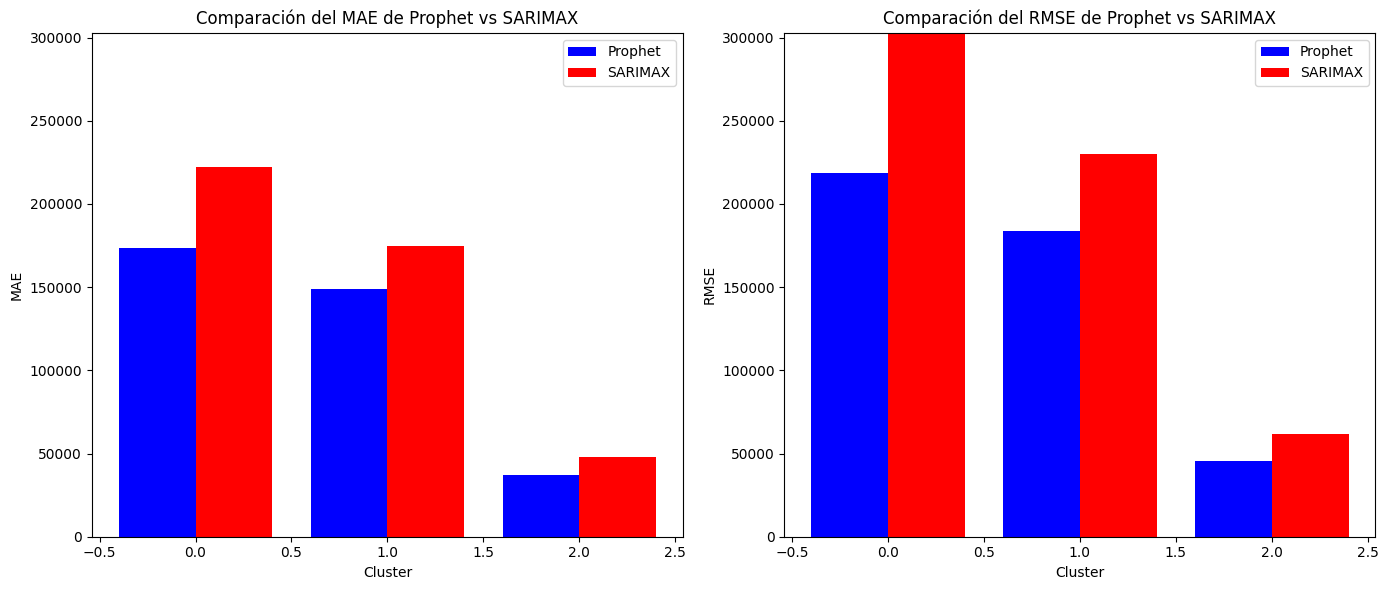

In [52]:
def compare_model_performance(prophet_df, sarimax_df):

    # Determinar el máximo para unificar la escala en los gráficos
    max_mae = max(prophet_df['MAE'].max(), sarimax_df['MAE'].max())
    max_rmse = max(prophet_df['RMSE'].max(), sarimax_df['RMSE'].max())
    max_y = max(max_mae, max_rmse)

    plt.figure(figsize=(14, 6))
    
    # Graficar MAE
    plt.subplot(1, 2, 1)
    plt.bar(prophet_df['Cluster'] - 0.2, prophet_df['MAE'], width=0.4, label='Prophet', color='blue')
    plt.bar(sarimax_df['Cluster'] + 0.2, sarimax_df['MAE'], width=0.4, label='SARIMAX', color='red')
    plt.title('Comparación del MAE de Prophet vs SARIMAX')
    plt.xlabel('Cluster')
    plt.ylabel('MAE')
    plt.ylim(0, max_y)  # Establecer la misma escala para ambos gráficos
    plt.legend()

    # Graficar RMSE
    plt.subplot(1, 2, 2)
    plt.bar(prophet_df['Cluster'] - 0.2, prophet_df['RMSE'], width=0.4, label='Prophet', color='blue')
    plt.bar(sarimax_df['Cluster'] + 0.2, sarimax_df['RMSE'], width=0.4, label='SARIMAX', color='red')
    plt.title('Comparación del RMSE de Prophet vs SARIMAX')
    plt.xlabel('Cluster')
    plt.ylabel('RMSE')
    plt.ylim(0, max_y)
    plt.legend()

    plt.tight_layout()
    plt.show()

compare_model_performance(prophet_performance_df, sarimax_performance_df)


In [20]:
# Guardar los modelos Prophet optimizados
for cluster, model in best_prophet_models.items():
    joblib.dump(model, f'best_prophet_model_cluster_{cluster}.pkl')
    print(f'Modelo Prophet optimizado para el Cluster {cluster} guardado.')


Modelo Prophet optimizado para el Cluster 1 guardado.
Modelo Prophet optimizado para el Cluster 0 guardado.
Modelo Prophet optimizado para el Cluster 2 guardado.
